In [50]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm

In [51]:
data = pd.read_excel('Dataset.xlsx', engine='openpyxl')
data.head()

,Team,Match Up,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
0,GSW,GSW vs. PHX,10/24/2023,L,240,104,36,101,35.6,10,...,78.6,18,31,49,19,11,6,11,23,-4
1,PHX,PHX @ GSW,10/24/2023,W,240,108,42,95,44.2,11,...,76.5,17,43,60,23,5,7,19,22,4
2,LAL,LAL @ DEN,10/24/2023,L,240,107,41,90,45.6,10,...,75,13,31,44,23,5,4,12,18,-12
3,DEN,DEN vs. LAL,10/24/2023,W,240,119,48,91,52.7,14,...,75,9,33,42,29,9,6,12,15,12
4,MEM,MEM vs. NOP,10/25/2023,L,240,104,38,91,41.8,12,...,80,8,29,37,23,8,7,13,19,-7


In [3]:
def Weighting_fun(L, alpha=0.5):
    Res = [alpha ** i for i in np.arange(L, 0, -1)]
    Res /= np.sum(Res)
    return Res

In [52]:
Home = []
for i in range(data.shape[0]):
    if data.iloc[:, 1][i][4:6]=='vs':
        Home.append(1)
    if data.iloc[:,1][i][4:6]=='@ ':
        Home.append(0)
data['home'] = np.array(Home)
data.loc[data['W/L'] == 'W', 'W/L'] = 1
data.loc[data['W/L'] == 'L', 'W/L'] = 0
data.loc[data['FT%']=='-','FT%'] = 1


Features = ['W/L','PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
for i in Features:
    data[i] = data[i].astype(float)

X_all = []
Y_all = []

The code below is professors baseline but removing weights, so we can regard it as baseline

In [26]:
for i in np.arange(300,data.shape[0]):
    Team_1 = data.iloc[i,0]
    Team_2 = data.iloc[i,1][-3::]
    Data_Previous_1 = (data.iloc[0:i,:][data.iloc[0:i,0]==Team_1])
    Data_Previous_2 = (data.iloc[0:i,:][data.iloc[0:i,0]==Team_2])
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == data.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1-data.iloc[i, -1])][Features])
    # W1 = Weighting_fun(Data_Previous_1_home.shape[0],0.4).reshape(-1,1)
    # W2 = Weighting_fun(Data_Previous_2_home.shape[0],0.4).reshape(-1,1)
    #Data_1 = np.array(Data_Previous_1_home[:,3::] * W1).mean(axis=0)
    #Data_2 = np.array(Data_Previous_2_home[:,3::] * W2).mean(axis=0)
    Data_1 = np.array(Data_Previous_1_home).mean(axis=0)
    Data_2 = np.array(Data_Previous_2_home).mean(axis=0)
    Diff = (Data_1 - Data_2).tolist() + [data.iloc[i,-1]]
    X_all.append(Diff)
    Y_all.append(data.iloc[i]['W/L'])

X = np.array(X_all)
print(X[:5])
y = np.array(Y_all)

[[ -0.1        -10.46666667  -1.4          3.46666667  -3.89333333
    0.83333333   2.23333333  -1.06666667  -8.5         -7.26666667
  -11.63333333   1.03333333  -2.3         -1.26666667   4.33333333
   -0.16666667   0.56666667  -0.53333333  -1.4        -16.33333333
    0.        ]
 [ -0.26666667 -10.93333333  -2.36666667  -3.3         -0.85333333
   -5.73333333 -10.96666667  -4.36        -0.46666667   0.83333333
   -8.99333333  -0.26666667   0.33333333   0.06666667   0.
   -0.6         -0.16666667  -0.83333333   0.1        -10.83333333
    1.        ]
 [  0.5          1.75        -2.08333333  -3.          -0.74166667
   -1.25        -7.58333333   4.325        7.16666667   5.41666667
   12.25         5.08333333   7.41666667  12.5         -4.91666667
    2.5          1.83333333   5.5         -2.33333333  25.5
    1.        ]
 [  0.16666667  14.16666667   2.33333333  -3.83333333   5.03333333
   -0.33333333  -1.66666667   1.96666667   9.83333333   8.83333333
   13.2         -1.66666667  

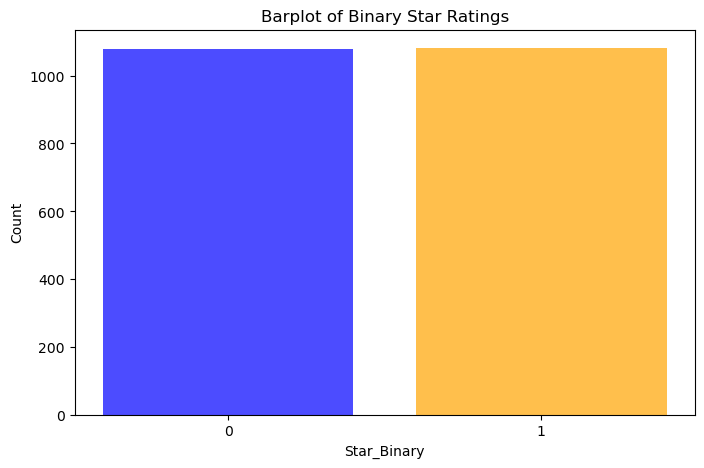

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the counts of each class (0 and 1)
unique, counts = np.unique(y, return_counts=True)

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(unique, counts, color=['blue', 'orange'], alpha=0.7)
plt.title("Barplot of Binary Star Ratings")
plt.xlabel("Star_Binary")
plt.ylabel("Count")
plt.xticks(unique)  # Ensure the x-axis shows 0 and 1
plt.show()

In [136]:
X = pd.DataFrame(X)
y = pd.Series(y)

# Ensure data is shuffled before splitting
# X_shuffled, y_shuffled = shuffle(X, y, random_state=1)
X_shuffled, y_shuffled = X, y
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    #'QDA': QuadraticDiscriminantAnalysis(),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=0),
    'Kernel SVM': SVC(kernel='rbf', random_state=0),
    'Linear SVM': SVC(kernel='linear', random_state=0)  # Add kernel SVM
}

# Initialize K-Fold with shuffle
kf = KFold(n_splits=5, shuffle=True, random_state=406)

# Store accuracies for each model
model_accuracies = {model_name: [] for model_name in models}

for train_index, test_index in kf.split(X_shuffled):
    # Split the data into training and testing sets
    X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
    
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[model_name].append(accuracy)

# Print results
for model_name, accuracies in model_accuracies.items():
    print(f"{model_name} Accuracy for each fold: {accuracies}")
    print(f"{model_name} Mean accuracy: {sum(accuracies) / len(accuracies):.2f}")

Random Forest Accuracy for each fold: [0.6180555555555556, 0.6666666666666666, 0.6458333333333334, 0.625, 0.6226851851851852]
Random Forest Mean accuracy: 0.64
Logistic Regression Accuracy for each fold: [0.6689814814814815, 0.7060185185185185, 0.6782407407407407, 0.6805555555555556, 0.6574074074074074]
Logistic Regression Mean accuracy: 0.68
Decision Tree Accuracy for each fold: [0.5856481481481481, 0.5763888888888888, 0.5949074074074074, 0.5717592592592593, 0.5486111111111112]
Decision Tree Mean accuracy: 0.58
AdaBoost Accuracy for each fold: [0.625, 0.6574074074074074, 0.6342592592592593, 0.6527777777777778, 0.6226851851851852]
AdaBoost Mean accuracy: 0.64
XGBoost Accuracy for each fold: [0.5995370370370371, 0.6828703703703703, 0.6203703703703703, 0.6203703703703703, 0.6018518518518519]
XGBoost Mean accuracy: 0.62
Kernel SVM Accuracy for each fold: [0.6342592592592593, 0.6828703703703703, 0.6481481481481481, 0.6319444444444444, 0.625]
Kernel SVM Mean accuracy: 0.64
Linear SVM Accura

The code below is the dataset after adding stability features.

In [88]:
for i in np.arange(300, data.shape[0]):
    Team_1 = data.iloc[i, 0]
    Team_2 = data.iloc[i, 1][-3::]
    
    # Extract historical data from both teams
    Data_Previous_1 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_1]
    Data_Previous_2 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_2]
    
    # Filter historical data based on teams
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == data.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - data.iloc[i, -1])][Features])
    
    # calculat weight
    W1 = Weighting_fun(Data_Previous_1_home.shape[0], 0.4).reshape(-1, 1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0], 0.4).reshape(-1, 1)
    
    # Weighted mean
    Data_1_mean = np.array(Data_Previous_1_home[:, 3:] * W1).mean(axis=0)
    Data_2_mean = np.array(Data_Previous_2_home[:, 3:] * W2).mean(axis=0)
    
    # Weighted variance
    Data_1_var = np.array(Data_Previous_1_home[:, 3:] * W1).var(axis=0)
    Data_2_var = np.array(Data_Previous_2_home[:, 3:] * W2).var(axis=0)
    
    # Stability
    Stability_1 = Data_1_mean / (Data_1_var + 1e-8)
    Stability_2 = Data_2_mean / (Data_2_var + 1e-8)
    
    Stability_Score_1 = Stability_1.mean()
    Stability_Score_2 = Stability_2.mean()
    
    # Calculate the stability difference
    Stability_Diff = Stability_Score_1 - Stability_Score_2
    
    # Original features difference
    Diff = (Data_1_mean - Data_2_mean).tolist() + [data.iloc[i, -1]]
    Diff.append(Stability_Diff)
    
    X_all.append(Diff)
    Y_all.append(data.iloc[i]['W/L'])

X = np.array(X_all)
print(X[:5])
y = np.array(Y_all)

[[ 3.71795071  0.99393912 -0.12170007  1.48127229 -0.96566614 -1.83129038
  -1.18116736 -1.60401305  0.35051774  1.11291302  1.46343076  1.96029472
  -0.58010187  0.11416721  0.05711766 -0.12807522 -5.54128875  0.
   0.17629707]
 [ 2.44991083  2.41805952  0.19236001 -0.53378232  2.2277172   0.05429696
   0.51752109  0.7712043   0.1681683   2.11599532  2.28416362  1.41439653
  -0.05810464  0.17953651  0.43680564  0.83202257 -0.93197016  1.
   0.02204719]
 [-6.59160335 -4.54052915 -1.19222626 -3.91995628 -2.337292   -1.90660726
  -3.3029263  -3.87551388  0.76091644 -1.3865804  -0.62566396 -3.38380545
  -0.69827919 -0.3508434  -0.41720182 -3.24864438  2.55029151  1.
  -0.01458255]
 [-0.79606066  1.46107898  0.53611593 -0.15333205  1.99644946  2.88175567
   2.61001864  4.12244072 -0.20413213  0.12071846 -0.08341366 -0.36029176
   0.42776814  0.13707345 -0.93872502  1.50125313  6.18867682  1.
  -0.08006846]
 [-7.60281617 -3.70423356 -1.84664025 -3.75588341 -4.19221385 -2.53128899
  -3.55851

All features: weighted, stability, home advantage, previous competition

In [5]:
for i in np.arange(300, data.shape[0]):
    Team_1 = data.iloc[i, 0]
    Team_2 = data.iloc[i, 1][-3::]
    
    Data_Previous_1 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_1]
    Data_Previous_2 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_2]
    
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == data.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - data.iloc[i, -1])][Features])
    
    W1 = Weighting_fun(Data_Previous_1_home.shape[0], 0.4).reshape(-1, 1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0], 0.4).reshape(-1, 1)
    
    Data_1_mean = np.array(Data_Previous_1_home[:, 3:] * W1).mean(axis=0)
    Data_2_mean = np.array(Data_Previous_2_home[:, 3:] * W2).mean(axis=0)
    
    Data_1_var = np.array(Data_Previous_1_home[:, 3:] * W1).var(axis=0)
    Data_2_var = np.array(Data_Previous_2_home[:, 3:] * W2).var(axis=0)
    
    Stability_1 = Data_1_mean / (Data_1_var + 1e-8)
    Stability_2 = Data_2_mean / (Data_2_var + 1e-8)
    
    Stability_Score_1 = Stability_1.mean()
    Stability_Score_2 = Stability_2.mean()
    
    Stability_Diff = Stability_Score_1 - Stability_Score_2
    
    # Calculate the characteristics of Previous Competitions
    # Find the history of matches between two teams
    Direct_Competitions = data.iloc[0:i, :][
        ((data.iloc[0:i, 0] == Team_1) & (data.iloc[0:i, 1].str[-3:] == Team_2)) |
        ((data.iloc[0:i, 0] == Team_2) & (data.iloc[0:i, 1].str[-3:] == Team_1))
    ]
    
    # Count the number and total number of Team_1 wins
    if not Direct_Competitions.empty:
        Team_1_Wins = sum(
            (Direct_Competitions['W/L'] == 1) &
            (Direct_Competitions.iloc[:, 0] == Team_1)
        )
        Team_2_Wins = sum(
            (Direct_Competitions['W/L'] == 1) &
            (Direct_Competitions.iloc[:, 0] == Team_2)
        )
        Previous_Competitions_Score = Team_1_Wins - Team_2_Wins
    else:
        Previous_Competitions_Score = 0  # If there is no historical match record, the value is 0
    
    Diff = (Data_1_mean - Data_2_mean).tolist() + [data.iloc[i, -1]]
    
    Diff.append(Stability_Diff)
    Diff.append(Previous_Competitions_Score)
    
    X_all.append(Diff)
    Y_all.append(data.iloc[i]['W/L'])

X = np.array(X_all)
print(X[:5])
y = np.array(Y_all)

[[ 3.71795071  0.99393912 -0.12170007  1.48127229 -0.96566614 -1.83129038
  -1.18116736 -1.60401305  0.35051774  1.11291302  1.46343076  1.96029472
  -0.58010187  0.11416721  0.05711766 -0.12807522 -5.54128875  0.
   0.17629707  0.        ]
 [ 2.44991083  2.41805952  0.19236001 -0.53378232  2.2277172   0.05429696
   0.51752109  0.7712043   0.1681683   2.11599532  2.28416362  1.41439653
  -0.05810464  0.17953651  0.43680564  0.83202257 -0.93197016  1.
   0.02204719 -1.        ]
 [-6.59160335 -4.54052915 -1.19222626 -3.91995628 -2.337292   -1.90660726
  -3.3029263  -3.87551388  0.76091644 -1.3865804  -0.62566396 -3.38380545
  -0.69827919 -0.3508434  -0.41720182 -3.24864438  2.55029151  1.
  -0.01458255  0.        ]
 [-0.79606066  1.46107898  0.53611593 -0.15333205  1.99644946  2.88175567
   2.61001864  4.12244072 -0.20413213  0.12071846 -0.08341366 -0.36029176
   0.42776814  0.13707345 -0.93872502  1.50125313  6.18867682  1.
  -0.08006846  0.        ]
 [-7.60281617 -3.70423356 -1.8466402

In [53]:
for i in np.arange(300, data.shape[0]):
    Team_1 = data.iloc[i, 0]
    Team_2 = data.iloc[i, 1][-3::]
    
    Data_Previous_1 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_1]
    Data_Previous_2 = data.iloc[0:i, :][data.iloc[0:i, 0] == Team_2]
    
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == data.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - data.iloc[i, -1])][Features])
    
    W1 = Weighting_fun(Data_Previous_1_home.shape[0], 0.4).reshape(-1, 1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0], 0.4).reshape(-1, 1)
    
    Data_1_mean = np.array(Data_Previous_1_home * W1).mean(axis=0)
    Data_2_mean = np.array(Data_Previous_2_home * W2).mean(axis=0)
    
    Data_1_var = np.array(Data_Previous_1_home * W1).var(axis=0)
    Data_2_var = np.array(Data_Previous_2_home * W2).var(axis=0)
    
    Stability_1 = Data_1_mean / (Data_1_var + 1e-8)
    Stability_2 = Data_2_mean / (Data_2_var + 1e-8)
    
    Stability_Score_1 = Stability_1.mean()
    Stability_Score_2 = Stability_2.mean()
    
    Stability_Diff = Stability_Score_1 - Stability_Score_2
    
    # Calculate the characteristics of Previous Competitions
    # Find the history of matches between two teams
    Direct_Competitions = data.iloc[0:i, :][
        ((data.iloc[0:i, 0] == Team_1) & (data.iloc[0:i, 1].str[-3:] == Team_2)) |
        ((data.iloc[0:i, 0] == Team_2) & (data.iloc[0:i, 1].str[-3:] == Team_1))
    ]
    
    # Count the number and total number of Team_1 wins
    if not Direct_Competitions.empty:
        Team_1_Wins = sum(
            (Direct_Competitions['W/L'] == 1) &
            (Direct_Competitions.iloc[:, 0] == Team_1)
        )
        Team_2_Wins = sum(
            (Direct_Competitions['W/L'] == 1) &
            (Direct_Competitions.iloc[:, 0] == Team_2)
        )
        Previous_Competitions_Score = Team_1_Wins - Team_2_Wins
    else:
        Previous_Competitions_Score = 0  # If there is no historical match record, the value is 0
    
    Diff = (Data_1_mean - Data_2_mean).tolist() + [data.iloc[i, -1]]
    
    Diff.append(Stability_Diff)
    Diff.append(Previous_Competitions_Score)
    
    X_all.append(Diff)
    Y_all.append(data.iloc[i]['W/L'])

X = np.array(X_all)
print(X[:5])
y = np.array(Y_all)

[[-1.15988228e-01  5.79918335e-01  1.26645439e+00  3.71795071e+00
   9.93939124e-01 -1.21700070e-01  1.48127229e+00 -9.65666142e-01
  -1.83129038e+00 -1.18116736e+00 -1.60401305e+00  3.50517743e-01
   1.11291302e+00  1.46343076e+00  1.96029472e+00 -5.80101875e-01
   1.14167211e-01  5.71176630e-02 -1.28075224e-01 -5.54128875e+00
   0.00000000e+00  9.46718124e-01  0.00000000e+00]
 [-3.73266350e-02  4.06956324e+00  1.91145313e+00  2.44991083e+00
   2.41805952e+00  1.92360007e-01 -5.33782316e-01  2.22771720e+00
   5.42969625e-02  5.17521090e-01  7.71204299e-01  1.68168301e-01
   2.11599532e+00  2.28416362e+00  1.41439653e+00 -5.81046364e-02
   1.79536514e-01  4.36805635e-01  8.32022569e-01 -9.31970161e-01
   1.00000000e+00  4.19237483e-01 -1.00000000e+00]
 [ 2.87356322e-03 -1.03701861e+01 -3.63567628e+00 -6.59160335e+00
  -4.54052915e+00 -1.19222626e+00 -3.91995628e+00 -2.33729200e+00
  -1.90660726e+00 -3.30292630e+00 -3.87551388e+00  7.60916438e-01
  -1.38658040e+00 -6.25663961e-01 -3.383

In [54]:
from sklearn.linear_model import LogisticRegression, Lasso
X = pd.DataFrame(X)
y = pd.Series(y)
# Step 1: Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)  # Standardize X to have zero mean and unit variance

# Step 2: Fit Logistic Regression with L1 regularization for binary model
lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)  # L1 penalty for feature selection
lasso_log_reg.fit(X_standardized, y)

# Step 3: Identify selected features
selected_features = X.columns[(lasso_log_reg.coef_ != 0).flatten()]  # Keep only features with non-zero coefficients
X_selected = X[selected_features]  # Subset original X with selected features

print(f"Selected features: {list(selected_features)}")
X_selected.head()

Selected features: [0, 2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


,0,2,3,4,5,6,7,10,12,13,14,15,16,17,18,19,20,21,22
0,-0.115988,1.266454,3.717951,0.993939,-0.121700,1.481272,-0.965666,-1.604013,1.112913,1.463431,1.960295,-0.580102,0.114167,0.057118,-0.128075,-5.541289,0.0,0.946718,0.0
1,-0.037327,1.911453,2.449911,2.418060,0.192360,-0.533782,2.227717,0.771204,2.115995,2.284164,1.414397,-0.058105,0.179537,0.436806,0.832023,-0.931970,1.0,0.419237,-1.0
2,0.002874,-3.635676,-6.591603,-4.540529,-1.192226,-3.919956,-2.337292,-3.875514,-1.386580,-0.625664,-3.383805,-0.698279,-0.350843,-0.417202,-3.248644,2.550292,1.0,0.053965,0.0
3,0.134149,0.930339,-0.796061,1.461079,0.536116,-0.153332,1.996449,4.122441,0.120718,-0.083414,-0.360292,0.427768,0.137073,-0.938725,1.501253,6.188677,1.0,-2.104739,0.0
4,-0.063715,-3.365861,-7.602816,-3.704234,-1.846640,-3.755883,-4.192214,-5.593110,-3.500366,-5.663095,-2.669701,-1.210358,-0.191737,-2.089562,-2.173723,-1.672848,0.0,0.485571,0.0


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Assume X is a DataFrame and y is a Series
X = pd.DataFrame(X)
y = pd.Series(y)

# Step 1: Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)  # Standardize X to have zero mean and unit variance

# Step 2: Generate a range of alpha values
alphas = np.logspace(-4, 2, 100)  # Range of alphas (smaller -> less regularization)

# Store selected features for each alpha
selected_features_list = []

# Loop through each alpha value
for alpha in alphas:
    # Fit Lasso model
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_standardized, y)
    
    # Identify selected features
    selected_features = X.columns[(lasso.coef_ != 0)]  # Use X.columns for feature names
    selected_features_list.append((alpha, list(selected_features)))

# Print selected features for the smallest alpha
print(f"Selected features for alpha = {alphas[0]}: {selected_features_list[0][1]}")

# Print selected features for the largest alpha
print(f"Selected features for alpha = {alphas[-1]}: {selected_features_list[-1][1]}")

Selected features for alpha = 0.0001: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Selected features for alpha = 100.0: []


c:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.726e-01, tolerance: 5.400e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.743e-01, tolerance: 5.400e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

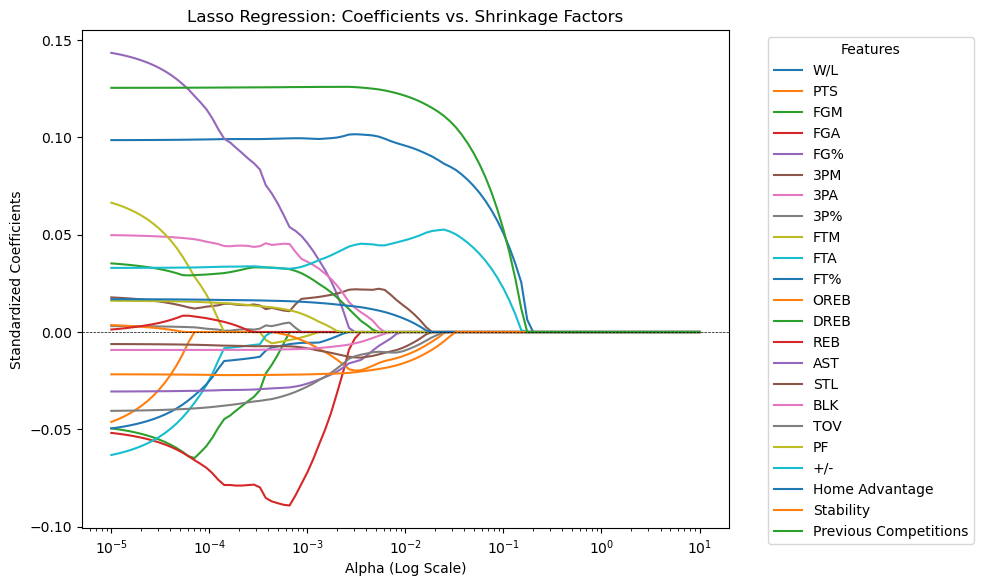

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso

feature_names = [
    "W/L", "PTS", "FGM", "FGA", "FG%", "3PM", "3PA", "3P%", "FTM", "FTA", 
    "FT%", "OREB", "DREB", "REB", "AST", "STL", "BLK", "TOV", "PF", "+/-", 
    "Home Advantage", "Stability", "Previous Competitions"
]

# Step 1: Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)  # Standardize X to have zero mean and unit variance

# Step 2: Generate a range of alpha (inverse of C) values
alphas = np.logspace(-5, 1, 100)  # Range of alphas (smaller -> less regularization)

# Step 3: Fit Logistic Regression for each alpha and collect coefficients
coefficients = []
for alpha in alphas:
    #lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=1/alpha, random_state=42)
    lasso_log_reg = Lasso(alpha = alpha, random_state=42)
    lasso_log_reg.fit(X_standardized, y)
    #coefficients.append(lasso_log_reg.coef_.flatten())
    coefficients.append(lasso_log_reg.coef_)

coefficients = np.array(coefficients)

# Step 4: Plot coefficients for removed features
# removed_features = [1, 8, 9, 11]  # Indices of removed features (from 0-based indexing)

plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):  # Loop through each feature
    plt.plot(alphas, coefficients[:, i], label=feature_names[i])

plt.xscale('log')
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Regression: Coefficients vs. Shrinkage Factors')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title="Features")
plt.tight_layout()
plt.show()

In [13]:
def z_score_normalize(df):
    return (df - df.mean()) / df.std()

In [40]:
# normalized X
X_normalized = z_score_normalize(X_selected)

X = pd.DataFrame(X_normalized)
y = pd.Series(y)

# Ensure data is shuffled before splitting
# X_shuffled, y_shuffled = shuffle(X, y, random_state=1)
X_shuffled, y_shuffled = X, y
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    #'QDA': QuadraticDiscriminantAnalysis(),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=0),
    'Kernel SVM': SVC(kernel='rbf', random_state=0),
    'Linear SVM': SVC(kernel='linear', random_state=0)  # Add kernel SVM
}

# Initialize K-Fold with shuffle
kf = KFold(n_splits=5, shuffle=True, random_state=406)

# Store accuracies for each model
model_accuracies = {model_name: [] for model_name in models}

for train_index, test_index in kf.split(X_shuffled):
    # Split the data into training and testing sets
    X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
    
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[model_name].append(accuracy)

# Print results
for model_name, accuracies in model_accuracies.items():
    print(f"{model_name} Accuracy for each fold: {accuracies}")
    print(f"{model_name} Mean accuracy: {sum(accuracies) / len(accuracies):.2f}")

Random Forest Accuracy for each fold: [0.7314814814814815, 0.75, 0.6990740740740741, 0.7083333333333334, 0.7152777777777778]
Random Forest Mean accuracy: 0.72
Logistic Regression Accuracy for each fold: [0.6851851851851852, 0.7245370370370371, 0.6921296296296297, 0.7129629629629629, 0.6782407407407407]
Logistic Regression Mean accuracy: 0.70
Decision Tree Accuracy for each fold: [0.6435185185185185, 0.6273148148148148, 0.6736111111111112, 0.6412037037037037, 0.6342592592592593]
Decision Tree Mean accuracy: 0.64
AdaBoost Accuracy for each fold: [0.6967592592592593, 0.7569444444444444, 0.7013888888888888, 0.7430555555555556, 0.6875]
AdaBoost Mean accuracy: 0.72
XGBoost Accuracy for each fold: [0.7060185185185185, 0.7175925925925926, 0.6990740740740741, 0.7222222222222222, 0.6944444444444444]
XGBoost Mean accuracy: 0.71
Kernel SVM Accuracy for each fold: [0.6851851851851852, 0.7407407407407407, 0.6875, 0.7222222222222222, 0.6620370370370371]
Kernel SVM Mean accuracy: 0.70
Linear SVM Accur

In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold
import pandas as pd

# Assume X_shuffled and y_shuffled are already prepared
kf = KFold(n_splits=5, shuffle=True, random_state=406)

# Initialize AdaBoost
adaboost = AdaBoostClassifier(random_state=0)

# Store predictions and ground truth for each fold
all_y_true = []
all_y_pred = []

# K-Fold Cross Validation
for train_index, test_index in kf.split(X_shuffled):
    X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
    
    # Train and predict with AdaBoost
    adaboost.fit(X_train, y_train)
    y_pred = adaboost.predict(X_test)
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Generate classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True, zero_division=0)

# Convert the classification report into a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Save the report to a CSV file
report_df.to_csv('adaboost_classification_report.csv', index=True)

# Print the DataFrame
print(report_df)

              precision    recall  f1-score     support
0.0            0.710171  0.731911  0.720877  1078.00000
1.0            0.724500  0.702403  0.713280  1082.00000
accuracy       0.717130  0.717130  0.717130     0.71713
macro avg      0.717335  0.717157  0.717079  2160.00000
weighted avg   0.717349  0.717130  0.717072  2160.00000


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold
import pandas as pd

# Assume X_shuffled and y_shuffled are already prepared
kf = KFold(n_splits=5, shuffle=True, random_state=406)

# Initialize Random Forest
random_forest = RandomForestClassifier(random_state=0)

# Store predictions and ground truth for each fold
all_y_true = []
all_y_pred = []

# K-Fold Cross Validation
for train_index, test_index in kf.split(X_shuffled):
    X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
    
    # Train and predict with Random Forest
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Generate classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True, zero_division=0)

# Convert the classification report into a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Save the report to a CSV file
report_df.to_csv('random_forest_classification_report.csv', index=True)

# Print the DataFrame
print(report_df)

              precision    recall  f1-score      support
0.0            0.716106  0.730056  0.723013  1078.000000
1.0            0.725730  0.711645  0.718619  1082.000000
accuracy       0.720833  0.720833  0.720833     0.720833
macro avg      0.720918  0.720850  0.720816  2160.000000
weighted avg   0.720927  0.720833  0.720812  2160.000000


Model Performance Metrics (Averaged Over Folds):
                     Precision (Class 0)  Recall (Class 0)  \
Random Forest                   0.714431          0.720961   
Logistic Regression             0.699090          0.697435   
Decision Tree                   0.644513          0.629339   
AdaBoost                        0.715907          0.722520   
XGBoost                         0.706207          0.704678   
Kernel SVM                      0.699648          0.682043   
Linear SVM                      0.700131          0.684603   

                     F1-Score (Class 0)  Precision (Class 1)  \
Random Forest                  0.717435             0.718071   
Logistic Regression            0.698147             0.699794   
Decision Tree                  0.636697             0.639098   
AdaBoost                       0.719120             0.721062   
XGBoost                        0.705289             0.706624   
Kernel SVM                     0.690426             0.689775   
Linear

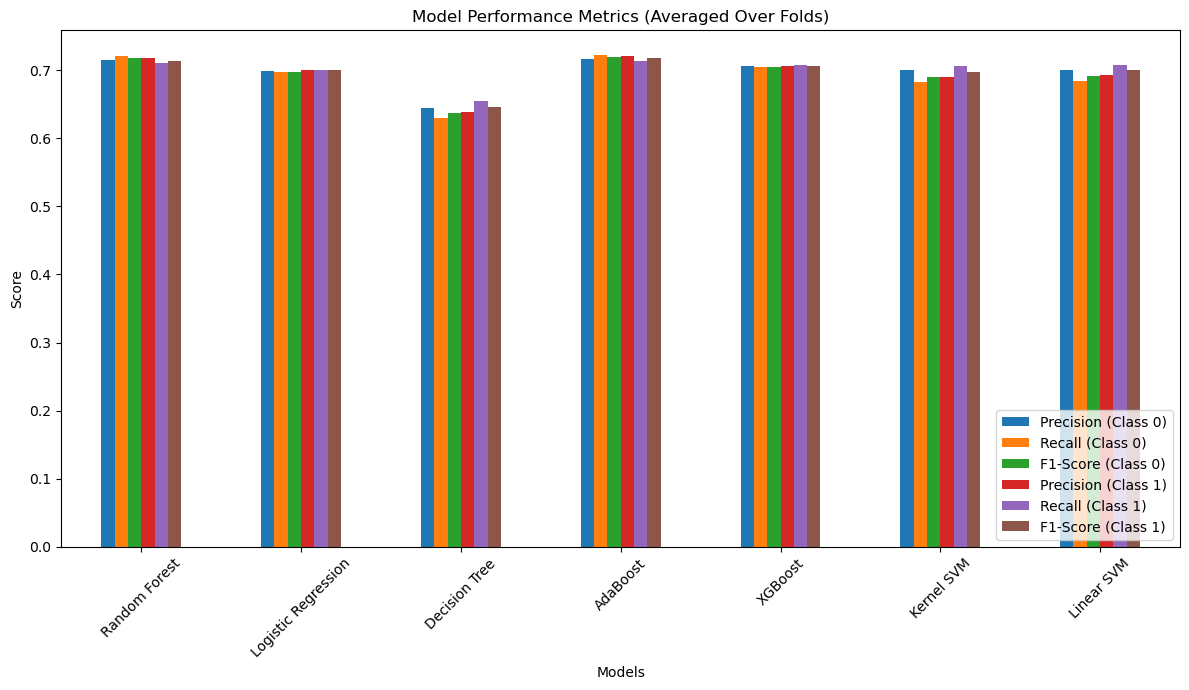

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Normalized data (assuming you have already normalized your features)
X_normalized = X_selected.apply(z_score_normalize)
X = pd.DataFrame(X_normalized)
y = pd.Series(y)

# Shuffle the data before splitting
X_shuffled, y_shuffled = shuffle(X, y, random_state=1)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=0),
    'Kernel SVM': SVC(kernel='rbf', random_state=0),
    'Linear SVM': SVC(kernel='linear', random_state=0)
}

# Initialize K-Fold with shuffle
kf = KFold(n_splits=5, shuffle=True, random_state=406)

# Store metrics for each model
model_reports = {model_name: [] for model_name in models}

for train_index, test_index in kf.split(X_shuffled):
    X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Get classification report
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        model_reports[model_name].append(report)

# Calculate mean metrics for each model
summary_metrics = {}
for model_name, reports in model_reports.items():
    # Aggregate metrics across folds for precision, recall, f1-score, etc.
    aggregated_metrics = {}
    for key in reports[0].keys():  # Iterate through each metric (e.g., '0.0', '1.0', 'accuracy', etc.)
        if isinstance(reports[0][key], dict):  # For nested dictionaries (e.g., '0.0', '1.0')
            aggregated_metrics[key] = {
                sub_key: np.mean([fold_report[key][sub_key] for fold_report in reports if key in fold_report])
                for sub_key in reports[0][key].keys()
            }
        else:  # For non-nested keys (e.g., 'accuracy')
            aggregated_metrics[key] = np.mean([fold_report[key] for fold_report in reports if key in fold_report])
    
    summary_metrics[model_name] = aggregated_metrics

# Convert the summary metrics to a DataFrame for visualization
df_summary = pd.DataFrame({
    model_name: {
        "Precision (Class 0)": summary_metrics[model_name]["0.0"]["precision"],
        "Recall (Class 0)": summary_metrics[model_name]["0.0"]["recall"],
        "F1-Score (Class 0)": summary_metrics[model_name]["0.0"]["f1-score"],
        "Precision (Class 1)": summary_metrics[model_name]["1.0"]["precision"],
        "Recall (Class 1)": summary_metrics[model_name]["1.0"]["recall"],
        "F1-Score (Class 1)": summary_metrics[model_name]["1.0"]["f1-score"],
        "Accuracy": summary_metrics[model_name]["accuracy"],
    }
    for model_name in summary_metrics
}).T

# Print the summary metrics as a table
print("Model Performance Metrics (Averaged Over Folds):")
print(df_summary)

# Plot results
df_summary[["Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)",
            "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"]].plot(kind='bar', figsize=(12, 7))
plt.title('Model Performance Metrics (Averaged Over Folds)')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Model Performance Metrics (Averaged Over Folds):
               Precision (Class 0)  Recall (Class 0)  F1-Score (Class 0)  \
Random Forest             0.714431          0.720961            0.717435   
AdaBoost                  0.715907          0.722520            0.719120   

               Precision (Class 1)  Recall (Class 1)  F1-Score (Class 1)  \
Random Forest             0.718071          0.710068            0.713749   
AdaBoost                  0.721062          0.713744            0.717283   

               Accuracy  
Random Forest  0.716667  
AdaBoost       0.718981  


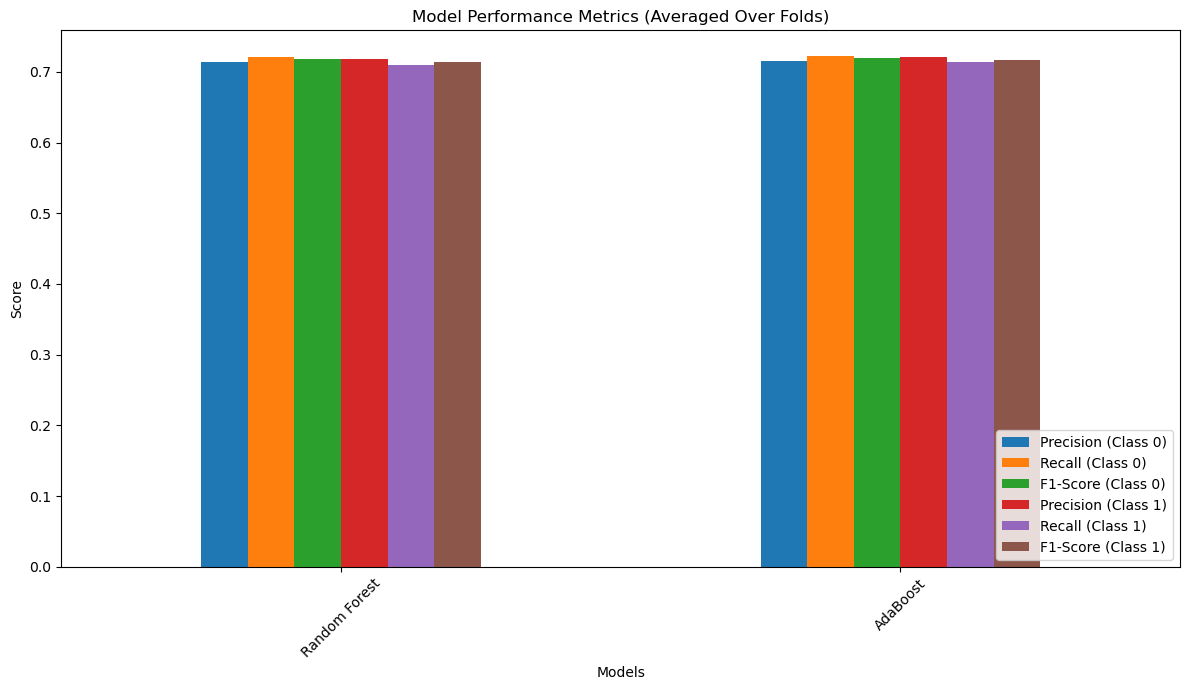

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Normalized data (assuming you have already normalized your features)
X_normalized = X_selected.apply(z_score_normalize)
X = pd.DataFrame(X_normalized)
y = pd.Series(y)

# Shuffle the data before splitting
X_shuffled, y_shuffled = shuffle(X, y, random_state=1)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
}

# Initialize K-Fold with shuffle
kf = KFold(n_splits=5, shuffle=True, random_state=406)

# Store metrics for each model
model_reports = {model_name: [] for model_name in models}

for train_index, test_index in kf.split(X_shuffled):
    X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Get classification report
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        model_reports[model_name].append(report)

# Calculate mean metrics for each model
summary_metrics = {}
for model_name, reports in model_reports.items():
    # Aggregate metrics across folds for precision, recall, f1-score, etc.
    aggregated_metrics = {}
    for key in reports[0].keys():  # Iterate through each metric (e.g., '0.0', '1.0', 'accuracy', etc.)
        if isinstance(reports[0][key], dict):  # For nested dictionaries (e.g., '0.0', '1.0')
            aggregated_metrics[key] = {
                sub_key: np.mean([fold_report[key][sub_key] for fold_report in reports if key in fold_report])
                for sub_key in reports[0][key].keys()
            }
        else:  # For non-nested keys (e.g., 'accuracy')
            aggregated_metrics[key] = np.mean([fold_report[key] for fold_report in reports if key in fold_report])
    
    summary_metrics[model_name] = aggregated_metrics

# Convert the summary metrics to a DataFrame for visualization
df_summary = pd.DataFrame({
    model_name: {
        "Precision (Class 0)": summary_metrics[model_name]["0.0"]["precision"],
        "Recall (Class 0)": summary_metrics[model_name]["0.0"]["recall"],
        "F1-Score (Class 0)": summary_metrics[model_name]["0.0"]["f1-score"],
        "Precision (Class 1)": summary_metrics[model_name]["1.0"]["precision"],
        "Recall (Class 1)": summary_metrics[model_name]["1.0"]["recall"],
        "F1-Score (Class 1)": summary_metrics[model_name]["1.0"]["f1-score"],
        "Accuracy": summary_metrics[model_name]["accuracy"],
    }
    for model_name in summary_metrics
}).T

# Print the summary metrics as a table
print("Model Performance Metrics (Averaged Over Folds):")
print(df_summary)

# Plot results
df_summary[["Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)",
            "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"]].plot(kind='bar', figsize=(12, 7))
plt.title('Model Performance Metrics (Averaged Over Folds)')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Here are the professors training methods code:

In [145]:
from sklearn import svm
X_train, X_test = X.iloc[0:1500, :], X.iloc[1500:, :]
y_train, y_test = y.iloc[0:1500], y.iloc[1500:]
model = svm.SVC()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(accuracy)

0.7045454545454546


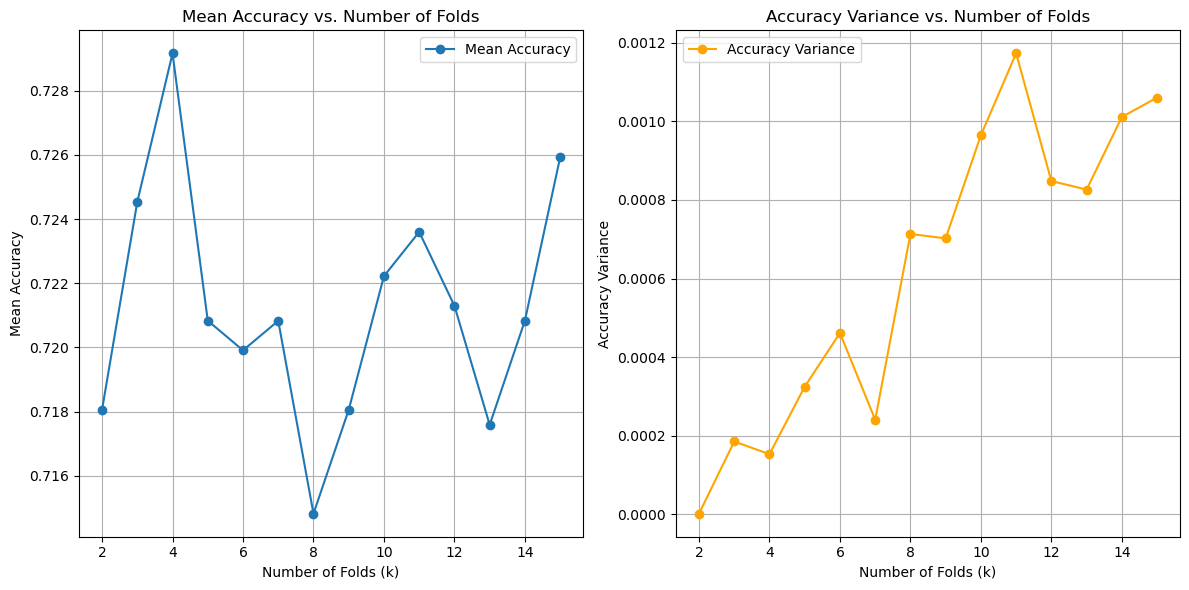

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to test
k_values = range(2, 16)  # Testing k from 2 to 15

# Dictionary to store mean accuracy and variance for each k
k_results = {'k': [], 'mean_accuracy': [], 'accuracy_variance': []}

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=406)
    model = RandomForestClassifier(random_state=0)  # Example model (can switch to others)
    fold_accuracies = []
    
    for train_index, test_index in kf.split(X_shuffled):
        # Split the data into training and testing sets
        X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
        y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        fold_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Record results for current k
    k_results['k'].append(k)
    k_results['mean_accuracy'].append(np.mean(fold_accuracies))
    k_results['accuracy_variance'].append(np.var(fold_accuracies))

# Plot mean accuracy and variance for different k values
plt.figure(figsize=(12, 6))

# Mean accuracy plot
plt.subplot(1, 2, 1)
plt.plot(k_results['k'], k_results['mean_accuracy'], marker='o', label='Mean Accuracy')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. Number of Folds')
plt.grid(True)
plt.legend()

# Accuracy variance plot
plt.subplot(1, 2, 2)
plt.plot(k_results['k'], k_results['accuracy_variance'], marker='o', label='Accuracy Variance', color='orange')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Accuracy Variance')
plt.title('Accuracy Variance vs. Number of Folds')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


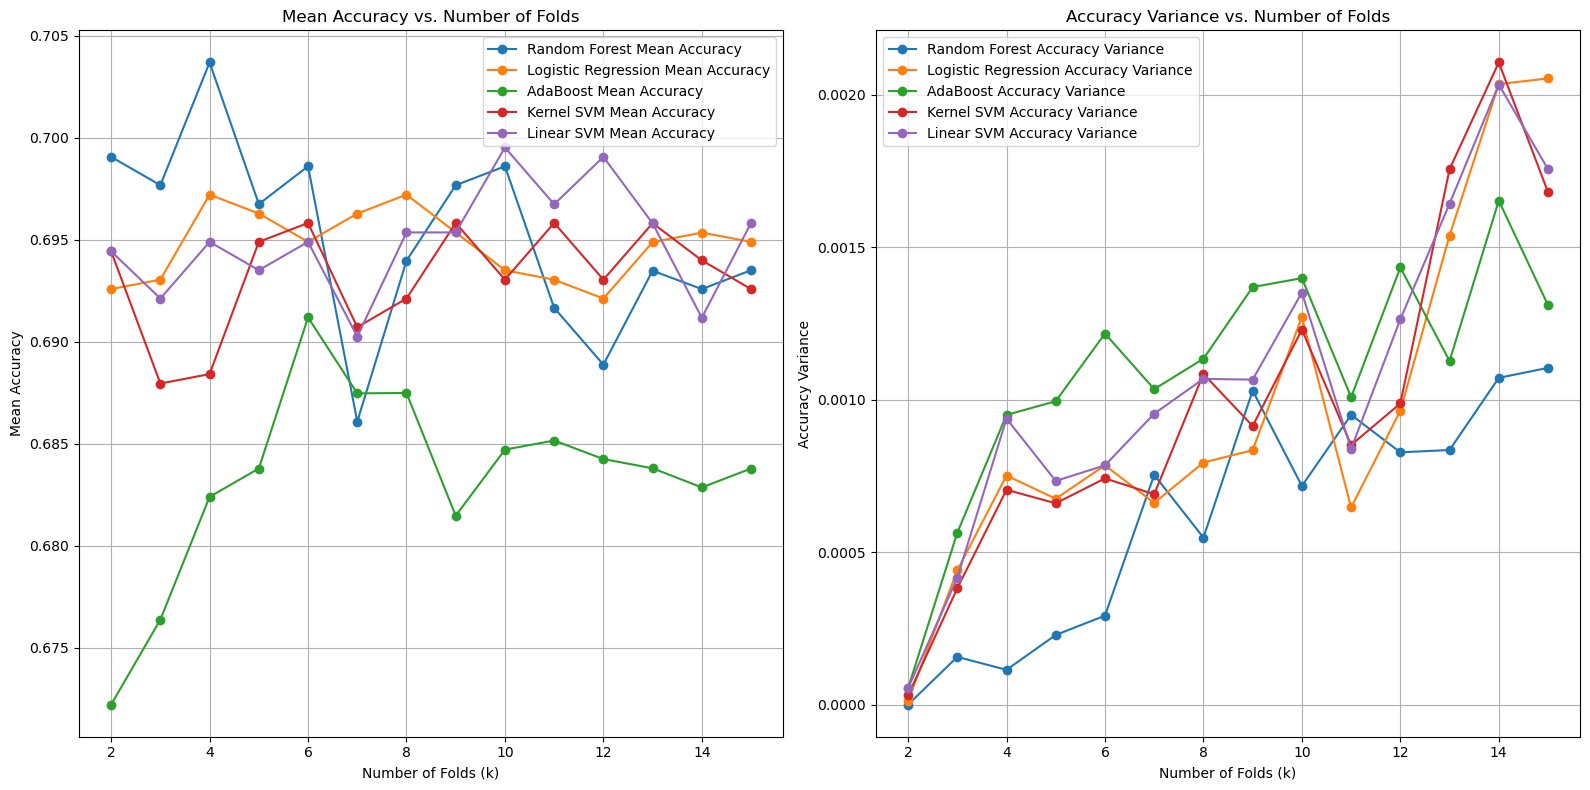

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Range of k values to test
k_values = range(2, 16)  # Testing k from 2 to 15

# Models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    'Kernel SVM': SVC(kernel='rbf', random_state=0),
    'Linear SVM': SVC(kernel='linear', random_state=0)
}

# Dictionary to store results for each model
model_results = {model_name: {'k': [], 'mean_accuracy': [], 'accuracy_variance': []} for model_name in models}

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=406)
    
    for model_name, model in models.items():
        fold_accuracies = []
        
        for train_index, test_index in kf.split(X_shuffled):
            # Split the data into training and testing sets
            X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
            y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            
            # Calculate accuracy
            fold_accuracies.append(accuracy_score(y_test, y_pred))
        
        # Record results for current k
        model_results[model_name]['k'].append(k)
        model_results[model_name]['mean_accuracy'].append(np.mean(fold_accuracies))
        model_results[model_name]['accuracy_variance'].append(np.var(fold_accuracies))

# Plot mean accuracy and variance for different k values
plt.figure(figsize=(16, 8))

# Mean accuracy plot
plt.subplot(1, 2, 1)
for model_name in models:
    plt.plot(
        model_results[model_name]['k'],
        model_results[model_name]['mean_accuracy'],
        marker='o',
        label=f'{model_name} Mean Accuracy'
    )
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. Number of Folds')
plt.grid(True)
plt.legend()

# Accuracy variance plot
plt.subplot(1, 2, 2)
for model_name in models:
    plt.plot(
        model_results[model_name]['k'],
        model_results[model_name]['accuracy_variance'],
        marker='o',
        label=f'{model_name} Accuracy Variance'
    )
plt.xlabel('Number of Folds (k)')
plt.ylabel('Accuracy Variance')
plt.title('Accuracy Variance vs. Number of Folds')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
